In [1]:
#!/usr/bin/env python
# coding: utf-8

import argparse
import logging
import os
import sys
import time
from decimal import Decimal
import glob

import numpy as np
import pandas as pd
import scanpy as sc
import torch
from captum.attr import IntegratedGradients
from numpy.lib.function_base import gradient
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr
import DaNN.mmd as mmd
import scanpypip.preprocessing as pp
import trainers as t
import utils as ut
from models import (AEBase, CVAEBase, DaNN, Predictor, PretrainedPredictor,
                    PretrainedVAEPredictor, TargetModel, VAEBase)
from scanpypip.utils import get_de_dataframe
from trajectory import trajectory
from sklearn.feature_selection import SelectKBest,SelectFdr
from sklearn.feature_selection import chi2


DATA_MAP={
"GSE117872":"data/GSE117872/GSE117872_good_Data_TPM.txt",
"GSE117309":'data/GSE117309/filtered_gene_bc_matrices_HBCx-22/hg19/',
"GSE117309_TAMR":'data/GSE117309/filtered_gene_bc_matrices_HBCx22-TAMR/hg19/',
"GSE121107":'data/GSE121107/GSM3426289_untreated_out_gene_exon_tagged.dge.txt',
"GSE121107_1H":'data/GSE121107/GSM3426290_entinostat_1hr_out_gene_exon_tagged.dge.txt',
"GSE121107_6H":'data/GSE121107/GSM3426291_entinostat_6hr_out_gene_exon_tagged.dge.txt',
"GSE111014":'data/GSE111014/',
"GSE110894":"data/GSE110894/GSE110894.csv",
"GSE122843":"data/GSE122843/GSE122843.txt",
"GSE112274":"data/GSE112274/GSE112274_cell_gene_FPKM.csv",
"GSE116237":"data/GSE116237/GSE116237_bulkRNAseq_expressionMatrix.txt",
"GSE108383":"data/GSE108383/GSE108383_Melanoma_fluidigm.txt",
"GSE140440":"data/GSE140440/GSE140440.csv",
"GSE129730":"data/GSE129730/GSE129730.h5ad",
"GSE149383":"data/GSE149383/erl_total_data_2K.csv",
"GSE110894_small":"data/GSE110894/GSE110894_small.h5ad",
"MIX-Seq":"data/10298696"

}

In [2]:
files = glob.glob("saved/models/1214*")

In [3]:
files

['saved/models\\1214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_F_lr_0.01_mod_new_sam_downsampling_DaNN.pkl',
 'saved/models\\1214data_GSE112274_drug_GEFITINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_F_lr_0.1_mod_new_sam_no_DaNN.pkl',
 'saved/models\\1214data_GSE117872HN120_drug_CISPLATIN_bottle_32_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.5_mod_new_sam_SMOTE_DaNN.pkl',
 'saved/models\\1214data_GSE117872HN137_drug_CISPLATIN_bottle_32_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.5_mod_new_sam_SMOTE_DaNN.pkl',
 'saved/models\\1214data_GSE140440_drug_DOCETAXEL_bottle_512_edim_256,128_pdim_256,128_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_no_DaNN.pkl',
 'saved/models\\1214data_GSE149383_drug_ERLOTINIB_bottle_512_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_F_lr_0.1_mod_new_sam_SMOTE_DaNN.pkl']

In [4]:
SELECTED_FILES = 0

# Load arguments

In [5]:
parser = argparse.ArgumentParser()
# data 
parser.add_argument('--source_data', type=str, default='data/ALL_expression.csv')
parser.add_argument('--label_path', type=str, default='data/ALL_label_binary_wf.csv')
parser.add_argument('--target_data', type=str, default="GSE110894")
parser.add_argument('--drug', type=str, default='I-BET-762')
parser.add_argument('--missing_value', type=int, default=1)
parser.add_argument('--test_size', type=float, default=0.2)
parser.add_argument('--valid_size', type=float, default=0.2)
parser.add_argument('--var_genes_disp', type=float, default=0)
parser.add_argument('--min_n_genes', type=int, default=0)
parser.add_argument('--max_n_genes', type=int, default=20000)
parser.add_argument('--min_g', type=int, default=200)
parser.add_argument('--min_c', type=int, default=3)
parser.add_argument('--cluster_res', type=float, default=0.3)
parser.add_argument('--remove_genes', type=int, default=1)
parser.add_argument('--mmd_weight', type=float, default=0.25)

# train
parser.add_argument('--source_model_path','-s', type=str, default='saved/models/BET_dw_256_AE.pkl')
parser.add_argument('--target_model_path', '-p',  type=str, default='saved/models/GSE110894_I-BET-762256AE')
parser.add_argument('--pretrain', type=str, default='saved/models/GSE110894_I-BET-762_256_ae.pkl')
parser.add_argument('--transfer', type=str, default="DaNN")

parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--epochs', type=int, default=500)
parser.add_argument('--batch_size', type=int, default=200)
parser.add_argument('--bottleneck', type=int, default=256)
parser.add_argument('--dimreduce', type=str, default="DAE")
parser.add_argument('--predictor', type=str, default="DNN")
parser.add_argument('--freeze_pretrain', type=int, default=0)
parser.add_argument('--source_h_dims', type=str, default="256,256")
parser.add_argument('--target_h_dims', type=str, default="256,256")
parser.add_argument('--p_h_dims', type=str, default="128,64")
parser.add_argument('--predition', type=str, default="classification")
parser.add_argument('--VAErepram', type=int, default=1)
parser.add_argument('--batch_id', type=str, default="HN137")
parser.add_argument('--load_target_model', type=int, default=0)
parser.add_argument('--GAMMA_mmd', type=int, default=1000)
parser.add_argument('--dropout', type=float, default=0.3,help='dropout')

parser.add_argument('--runs', type=int, default=1)

# Analysis
parser.add_argument('--n_DL_genes', type=int, default=50)
parser.add_argument('--n_DE_genes', type=int, default=50)


# misc
parser.add_argument('--message', '-m',  type=str, default='message')
parser.add_argument('--output_name', '-n',  type=str, default='saved/results')
parser.add_argument('--logging_file', '-l',  type=str, default='saved/logs/transfer_')

#
args, unknown = parser.parse_known_args()

In [6]:
## Testing the args covering
selected_model = files[SELECTED_FILES]
split_name = selected_model.split("_")
print(split_name[1::2])
print(split_name[0::2])

['GSE110894', 'I.BET.762', '128', '512,256', '256,128', 'DAE', '0.1', 'F', '0.01', 'new', 'downsampling']
['saved/models\\1214data', 'drug', 'bottle', 'edim', 'pdim', 'model', 'dropout', 'gene', 'lr', 'mod', 'sam', 'DaNN.pkl']


In [7]:
paras = (split_name[1::2])
para_names = (split_name[0::2])

args.source_h_dims = paras[3]
args.target_h_dims = paras[3]
args.p_h_dims = paras[4]
args.bottleneck = int(paras[2])
args.drug = paras[1]
args.dropout = float(paras[6])

if(paras[0].find("GSE117872")>=0):
    args.target_data = "GSE117872"
    args.batch_id = paras[0].split("GSE117872")[1]
elif(paras[0].find("MIX-Seq")>=0):
    args.target_data = "MIX-Seq"
    args.batch_id = paras[0].split("MIX-Seq")[1]    
else:
    args.target_data = paras[0]
    
args.target_model_path = selected_model

In [8]:
paras

['GSE110894',
 'I.BET.762',
 '128',
 '512,256',
 '256,128',
 'DAE',
 '0.1',
 'F',
 '0.01',
 'new',
 'downsampling']

In [9]:
# Read parameters
data_name = args.target_data
epochs = args.epochs
dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
na = args.missing_value
data_path = DATA_MAP[args.target_data]
test_size = args.test_size
select_drug = args.drug
freeze = args.freeze_pretrain
valid_size = args.valid_size
g_disperson = args.var_genes_disp
min_n_genes = args.min_n_genes
max_n_genes = args.max_n_genes
source_model_path = args.source_model_path
target_model_path = args.target_model_path 
log_path = args.logging_file
batch_size = args.batch_size
encoder_hdims = args.source_h_dims.split(",")
encoder_hdims = list(map(int, encoder_hdims))
source_data_path = args.source_data 
pretrain = args.pretrain
prediction = args.predition
data_name = args.target_data
label_path = args.label_path
reduce_model = args.dimreduce
predict_hdims = args.p_h_dims.split(",")
predict_hdims = list(map(int, predict_hdims))
leiden_res = args.cluster_res
load_model = bool(args.load_target_model)

In [10]:
if(args.target_data!="GSE117872"):
    adata_path = glob.glob("D://pyws//trainsource//saved//adata//review//*"+args.target_data+"*")
else:
    adata_path = glob.glob("D://pyws//trainsource//saved//adata//review//*"+args.batch_id+"*")

In [11]:
adata_path

['D://pyws//trainsource//saved//adata//review\\GSE1108941214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.01_mod_new_sam_downsampling.h5ad']

In [12]:
adata_final = sc.read_h5ad(adata_path[0])

In [13]:
if(data_name!="MIX-Seq"):
    adata = pp.read_sc_file(data_path)

    if data_name == 'GSE117872':
        adata =  ut.specific_process(adata,dataname=data_name,select_origin=args.batch_id)
    elif data_name =='GSE122843':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE110894':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE112274':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE116237':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE108383':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE140440':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE129730':
        adata =  ut.specific_process(adata,dataname=data_name)
    elif data_name =='GSE149383':
        adata =  ut.specific_process(adata,dataname=data_name)
    else:
        adata=adata
else:
    # Can be expt1, expt3, and expt10
    # Add process mix-seq
    expID = args.batch_id
    drug_path = args.drug.capitalize()
    adata = ut.process_mix_seq(drug=drug_path,expt=expID)



In [14]:
#adata_final.var.index.intersection(adata.var.index)

In [15]:
#adata = adata[adata_final.obs.index,adata_final.var.index]

In [16]:
adata

AnnData object with n_obs × n_vars = 1504 × 25921
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity'

In [17]:
adata_final

AnnData object with n_obs × n_vars = 1419 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [18]:
if(data_name!="GSE149383"):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    adata = pp.cal_ncount_ngenes(adata)
    adata = pp.receipe_my(adata,l_n_genes=min_n_genes,r_n_genes=max_n_genes,filter_mincells=0,percent_mito = 100,
                            filter_mingenes=0,normalize=True,log=True)

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(1419, 21182)


In [19]:
adata

AnnData object with n_obs × n_vars = 1419 × 21182
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [20]:
if(data_name!="GSE149383"):

    sc.pp.highly_variable_genes(adata,min_disp=g_disperson,max_disp=np.inf,max_mean=6)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
else:
    adata.raw = adata

data=adata.X

In [21]:
adata

View of AnnData object with n_obs × n_vars = 1419 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [22]:
sc.tl.pca(adata,svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
# Generate cluster labels
sc.tl.leiden(adata,resolution=leiden_res)
sc.tl.umap(adata)
adata.obs['leiden_origin']= adata.obs['leiden']
adata.obsm['X_umap_origin']= adata.obsm['X_umap']
data_c = adata.obs['leiden'].astype("long").to_list()

D:\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [23]:
mmscaler = preprocessing.MinMaxScaler()

try:
    data = mmscaler.fit_transform(data)

except:
    logging.warning("Sparse data , transfrom to dense")

    # Process sparse data
    data = data.todense()
    data = mmscaler.fit_transform(data)

In [24]:
select_drug

'I.BET.762'

In [25]:
Xtarget_train, Xtarget_valid, Ctarget_train, Ctarget_valid = train_test_split(data,data_c, test_size=valid_size, random_state=42)


# Select the device of gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
# Assuming that we are on a CUDA machine, this should print a CUDA device:
#logging.info(device)
print(device)
torch.cuda.set_device(device)

# Construct datasets and data loaders
Xtarget_trainTensor = torch.FloatTensor(Xtarget_train).to(device)
Xtarget_validTensor = torch.FloatTensor(Xtarget_valid).to(device)
#print(Xtarget_validTensor.shape)
# Use leiden label if CVAE is applied 
Ctarget_trainTensor = torch.LongTensor(Ctarget_train).to(device)
Ctarget_validTensor = torch.LongTensor(Ctarget_valid).to(device)
#print("C",Ctarget_validTensor )
X_allTensor = torch.FloatTensor(data).to(device)
C_allTensor = torch.LongTensor(data_c).to(device)


train_dataset = TensorDataset(Xtarget_trainTensor, Ctarget_trainTensor)
valid_dataset = TensorDataset(Xtarget_validTensor, Ctarget_validTensor)

Xtarget_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
Xtarget_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

dataloaders_pretrain = {'train':Xtarget_trainDataLoader,'val':Xtarget_validDataLoader}
#print('START SECTION OF LOADING SC DATA TO THE TENSORS')
################################################# START SECTION OF LOADING SC DATA TO THE TENSORS #################################################

################################################# START SECTION OF LOADING BULK DATA  #################################################
# Read source data
data_r=pd.read_csv(source_data_path,index_col=0)
label_r=pd.read_csv(label_path,index_col=0)
label_r=label_r.fillna(na)

# Extract labels
selected_idx = label_r.loc[:,select_drug]!=na
label = label_r.loc[selected_idx.index,select_drug]
data_r = data_r.loc[selected_idx.index,:]
label = label.values.reshape(-1,1)


le = preprocessing.LabelEncoder()
label = le.fit_transform(label)
dim_model_out = 2

# Process source data
mmscaler = preprocessing.MinMaxScaler()
source_data = mmscaler.fit_transform(data_r)

# Split source data
Xsource_train_all, Xsource_test, Ysource_train_all, Ysource_test = train_test_split(source_data,label, test_size=test_size, random_state=42)
Xsource_train, Xsource_valid, Ysource_train, Ysource_valid = train_test_split(Xsource_train_all,Ysource_train_all, test_size=valid_size, random_state=42)

# Transform source data
# Construct datasets and data loaders
Xsource_trainTensor = torch.FloatTensor(Xsource_train).to(device)
Xsource_validTensor = torch.FloatTensor(Xsource_valid).to(device)

Ysource_trainTensor = torch.LongTensor(Ysource_train).to(device)
Ysource_validTensor = torch.LongTensor(Ysource_valid).to(device)

sourcetrain_dataset = TensorDataset(Xsource_trainTensor, Ysource_trainTensor)
sourcevalid_dataset = TensorDataset(Xsource_validTensor, Ysource_validTensor)


Xsource_trainDataLoader = DataLoader(dataset=sourcetrain_dataset, batch_size=batch_size, shuffle=True)
Xsource_validDataLoader = DataLoader(dataset=sourcevalid_dataset, batch_size=batch_size, shuffle=True)

dataloaders_source = {'train':Xsource_trainDataLoader,'val':Xsource_validDataLoader}
#print('END SECTION OF LOADING BULK DATA')
################################################# END SECTION OF LOADING BULK DATA  #################################################

cuda:0


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [26]:
args.dropout

0.1

In [27]:
################################################# START SECTION OF MODEL CUNSTRUCTION  #################################################
# Construct target encoder
if reduce_model == "AE":
    encoder = AEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
    loss_function_e = nn.MSELoss()
elif reduce_model == "VAE":
    encoder = VAEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
if reduce_model == "DAE":
    encoder = AEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims,drop_out=args.dropout)
    loss_function_e = nn.MSELoss()        

In [28]:
dim_model_out = 2
# Load AE model
if reduce_model == "AE":
    source_model = PretrainedPredictor(input_dim=Xsource_train.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims, 
            hidden_dims_predictor=predict_hdims,output_dim=dim_model_out,
            pretrained_weights=None,freezed=freeze,drop_out=args.dropout,drop_out_predictor=args.dropout)

    #source_model.load_state_dict(torch.load(selected_model))
    source_encoder = source_model
if reduce_model == "DAE":
    source_model = PretrainedPredictor(input_dim=Xsource_train.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims, 
            hidden_dims_predictor=predict_hdims,output_dim=dim_model_out,
            pretrained_weights=None,freezed=freeze,drop_out=args.dropout,drop_out_predictor=args.dropout)

    #source_model.load_state_dict(torch.load(selected_model))
    source_encoder = source_model    
# Load VAE model
elif reduce_model in ["VAE"]:
    source_model = PretrainedVAEPredictor(input_dim=Xsource_train.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims, 
            hidden_dims_predictor=predict_hdims,output_dim=dim_model_out,
            pretrained_weights=None,freezed=freeze,z_reparam=bool(args.VAErepram),drop_out=args.dropout,drop_out_predictor=args.dropout)
    #source_model.load_state_dict(torch.load(selected_model))
    source_encoder = source_model

In [29]:
# Set DaNN model
DaNN_model = DaNN(source_model=source_encoder,target_model=encoder)
DaNN_model.to(device)

DaNN(
  (source_model): PretrainedPredictor(
    (encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=15962, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout(p=0.1, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout(p=0.1, inplace=False)
      )
    )
    (bottleneck): Linear(in_features=256, out_features=128, bias=True)
    (predictor): Predictor(
      (predictor): Sequential(
        (0): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): Linear(in_featur

In [30]:
DaNN_model.load_state_dict(torch.load(selected_model))

<All keys matched successfully>

In [31]:
encoder = DaNN_model.target_model
source_model = DaNN_model.source_model

In [32]:
embedding_tensors = encoder.encode(X_allTensor)
embeddings = embedding_tensors.detach().cpu().numpy()

In [33]:
if(args.target_data!="GSE117872"):
    adata_path = glob.glob("D://pyws//trainsource//saved//adata//review//*"+args.target_data+"*")
else:
    adata_path = glob.glob("D://pyws//trainsource//saved//adata//review//*"+args.batch_id+"*")

In [34]:
adata_final = sc.read_h5ad(adata_path[0])

In [35]:
adata_final.obsm["X_Trans"] = embeddings

In [60]:
adata_final.obs.loc[adata_final.obs["Sample name"]!='EMPTY ']

,Plate#,Well position,Sample name,Index-Sort condition,Well index,sensitive,sensitivity,Sensitive_score,Resistant_score,n_genes,...,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds,leiden_trans,dpt_pseudotime
RPI1_A3,RPI1,A3,MA9 IBET RESISTANT CELLS,GR+,GGTCTATG,0,Resistant,-2.726364,14.205806,7132,...,0.0,3,3,5.279347e-01,1,0.000138,0,0.999864,5,0.854432
RPI1_A4,RPI1,A4,MA9 IBET RESISTANT CELLS,GR+,GTCCGAAT,0,Resistant,-2.200808,10.421614,6815,...,0.0,3,3,6.765910e-01,1,0.000264,0,0.999738,5,0.878704
RPI1_A5,RPI1,A5,MA9 IBET RESISTANT CELLS,GR+,TAGTGCGT,0,Resistant,-1.273636,5.788548,4951,...,0.0,3,3,7.460276e-01,1,0.006229,0,0.993606,3,0.791111
RPI1_A6,RPI1,A6,MA9 IBET RESISTANT CELLS,GR+,GACTGTAC,0,Resistant,-3.492323,16.025484,7615,...,0.0,3,3,3.873717e-01,0,0.000051,0,0.999950,9,0.813359
RPI1_A7,RPI1,A7,MA9 IBET RESISTANT CELLS,GR+,TCCAGTAG,0,Resistant,-2.236667,13.070160,6688,...,0.0,3,3,4.933213e-01,0,0.000098,0,0.999904,8,0.839295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPI7_P18,RPI7,P18,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,ACGTGTGT,0,Resistant,-1.348788,8.079032,5421,...,0.0,1,1,4.762616e-01,0,0.001626,0,0.998354,3,0.843039
RPI7_P19,RPI7,P19,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,TCAGCGTA,0,Resistant,-1.234040,8.462097,5293,...,0.0,1,1,3.158419e-01,0,0.000260,0,0.999741,1,0.870368
RPI7_P20,RPI7,P20,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,AGAAGAGG,0,Resistant,-0.823939,5.184032,4101,...,0.0,1,1,8.651327e-02,0,0.006288,0,0.993544,3,0.581737
RPI7_P21,RPI7,P21,EMPTY,EMPTY,TATCCGGA,1,Sensitive,-0.295859,1.591129,2012,...,0.0,1,1,3.284501e-07,0,0.001837,0,0.998129,5,0.523068


In [61]:
try:
    emptyidx = adata_final.obs.loc[adata_final.obs["Sample name"]!='EMPTY'].index
    
    adata_final=adata_final[emptyidx]
except:
    print('No filtering')

No filtering


In [37]:
color_list = ["leiden","sensitivity",'sens_preds']
title_list = ['Cluster',"Ground truth","Probability"]
color_score_list = color_list

# Run embeddings using transfered embeddings
sc.pp.neighbors(adata_final,use_rep='X_Trans',key_added="Trans")
sc.tl.umap(adata_final,neighbors_key="Trans")
sc.tl.leiden(adata_final,neighbors_key="Trans",key_added="leiden_trans",resolution=leiden_res)
sc.pl.umap(adata_final,color=color_list,neighbors_key="Trans",
           save=paras[0]+args.transfer+args.dimreduce+"_TL.tiff",
           show=False,title=title_list)
# Plot cell score on umap
#sc.pl.umap(adata,color=color_score_list,neighbors_key="Trans",save=data_name+args.transfer+args.dimreduce+"_score_TL"+now,show=False,title=color_score_list)

In [38]:
sc.tl.draw_graph(adata_final)

In [39]:
adata.obs

,Plate#,Well position,Sample name,Index-Sort condition,Well index,sensitive,sensitivity,n_genes,n_genes_by_counts,total_counts,total_counts_mt-,pct_counts_mt-,total_counts_rps,pct_counts_rps,total_counts_rpl,pct_counts_rpl,leiden,leiden_origin
RPI1_A3,RPI1,A3,MA9 IBET RESISTANT CELLS,GR+,GGTCTATG,0,Resistant,7132,7132,31495.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
RPI1_A4,RPI1,A4,MA9 IBET RESISTANT CELLS,GR+,GTCCGAAT,0,Resistant,6815,6815,28320.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
RPI1_A5,RPI1,A5,MA9 IBET RESISTANT CELLS,GR+,TAGTGCGT,0,Resistant,4951,4951,14918.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
RPI1_A6,RPI1,A6,MA9 IBET RESISTANT CELLS,GR+,GACTGTAC,0,Resistant,7615,7615,42600.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
RPI1_A7,RPI1,A7,MA9 IBET RESISTANT CELLS,GR+,TCCAGTAG,0,Resistant,6688,6688,26241.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPI7_P18,RPI7,P18,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,ACGTGTGT,0,Resistant,5421,5421,18256.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
RPI7_P19,RPI7,P19,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,TCAGCGTA,0,Resistant,5293,5293,16259.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
RPI7_P20,RPI7,P20,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,AGAAGAGG,0,Resistant,4101,4101,11711.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
RPI7_P21,RPI7,P21,EMPTY,EMPTY,TATCCGGA,1,Sensitive,2012,2012,3670.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


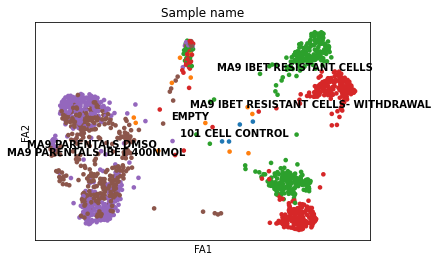

In [40]:
sc.pl.draw_graph(adata_final, color='Sample name', legend_loc='on data')


In [41]:
sc.tl.diffmap(adata_final)
sc.pp.neighbors(adata_final, n_neighbors=10, use_rep='X_diffmap')

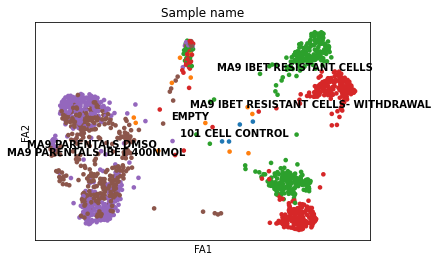

In [42]:
sc.pl.draw_graph(adata_final, color='Sample name', legend_loc='on data')

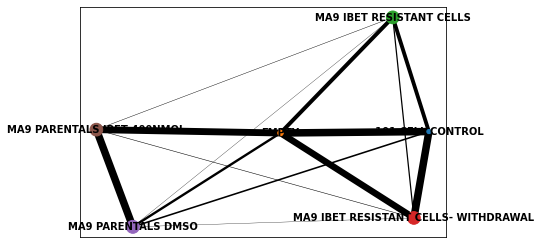

In [43]:
sc.tl.paga(adata_final, groups='Sample name')
sc.pl.paga(adata_final, color=['Sample name'])

In [44]:
sc.tl.draw_graph(adata_final, init_pos='paga')

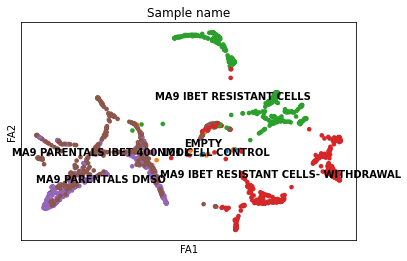

In [45]:
sc.pl.draw_graph(adata_final, color=['Sample name'], legend_loc='on data')

In [46]:
adata_final.uns['iroot'] = np.flatnonzero(adata_final.obs['sensitivity']  == 'Sensitive')[0]

In [47]:
sc.tl.dpt(adata_final)


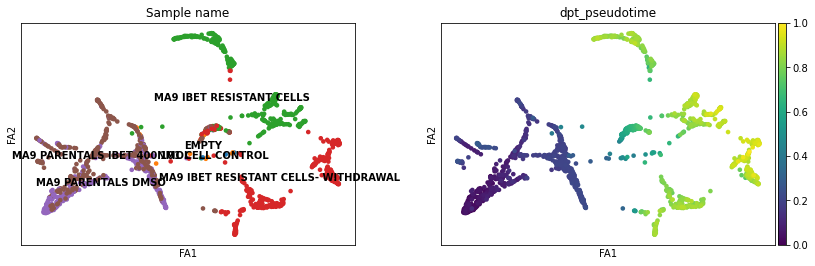

In [48]:
sc.pl.draw_graph(adata_final, color=['Sample name', 'dpt_pseudotime'], legend_loc='on data')


In [49]:
sc.pp.neighbors(adata_final, n_neighbors=10, use_rep='X_Trans',key_added='Trans')

In [50]:
adata_final

AnnData object with n_obs × n_vars = 1416 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', 'leiden_trans', 'dpt_pseudotime'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Trans', 'leiden_colors', 'sensitivity_colors', 'draw_graph', 'Sample name_colors', 'diffmap_evals', 'paga', 'Sample name_sizes', 'iroot'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin', 'X_Trans', 'X_draw_graph_fa', 'X_diffmap'
    

In [51]:
adata_final

AnnData object with n_obs × n_vars = 1416 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', 'leiden_trans', 'dpt_pseudotime'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Trans', 'leiden_colors', 'sensitivity_colors', 'draw_graph', 'Sample name_colors', 'diffmap_evals', 'paga', 'Sample name_sizes', 'iroot'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin', 'X_Trans', 'X_draw_graph_fa', 'X_diffmap'
    

In [52]:
# sc.tl.diffmap(adata_final,neighbors_key="Trans")
# sc.pp.neighbors(adata_final, n_neighbors=10, use_rep='X_diffmap')
# sc.tl.draw_graph(adata_final)

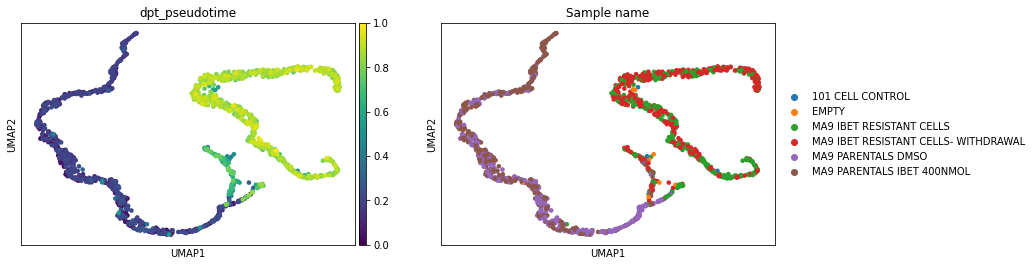

In [59]:
sc.pl.umap(adata_final,color=['dpt_pseudotime','Sample name'])

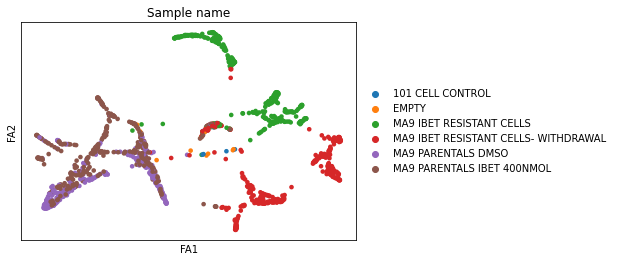

In [54]:
sc.pl.draw_graph(adata_final, color='Sample name')

In [55]:
sc.tl.paga(adata_final, groups='Sample name')

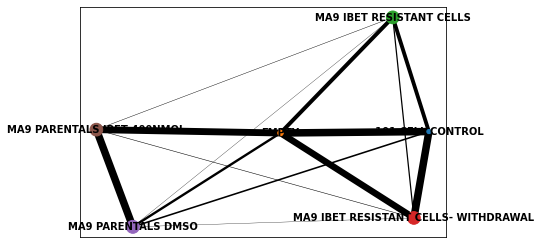

In [56]:
sc.pl.paga(adata_final, color=['Sample name'])

In [57]:
sc.tl.draw_graph(adata_final, init_pos='paga')


In [58]:
sc.pl.draw_graph(adata, color=['Sample name'], legend_loc='on data')


KeyError: 'draw_graph'